In [1]:
from IPython.display import Audio
from IPython import display
the_voice = './sounds/chose_a_voice.wav'
the_creation = './sounds/You_created_me.wav'

import tensorflow as tf
from tensorflow import keras

# Error: Node: 'sequential_3/dropout_4/dropout/random_uniform/RandomUniform'
# OOM when allocating tensor with shape[256,180,120,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
# 	 [[{{node sequential_3/dropout_4/dropout/random_uniform/RandomUniform}}]]
# the solution to thi is report_tensor_allocations_upon_oom = True

run_opts = tf.compat.v1.RunOptions(report_tensor_allocations_upon_oom=True)
runmeta = tf.compat.v1.RunMetadata()

from tensorflow.keras import layers
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time
import wandb

# pip install wandb
# wandb login
# 65bacd21c40b0085e299e05ea94b552d5119b7bc

wandb.init(project="Anime Creation", entity="skycladai")

print("Note! You will need tensorflow-gpu version 2.8.0 or higher. Your version is", tf.__version__)
import sys
print(sys.executable)

Audio(url=the_voice, autoplay=True, rate=48000)

<IPython.lib.display.Audio object>

In [2]:
%%time
# BATCH_SIZE = 254 # this cause memory allocation failure
BATCH_SIZE = 64
IMAGE_WIDTH = 240
IMAGE_LENGTH = 360
ORIGINAL_IMAGE_SIZE = (360, 240)
RGB = 3
BUFFER_SIZE = 58085
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

x_train = tf.keras.preprocessing.image_dataset_from_directory( directory="./dataset/", validation_split=0.3, subset="training" ,label_mode=None, batch_size=BATCH_SIZE, image_size=ORIGINAL_IMAGE_SIZE, seed=123 , shuffle=BUFFER_SIZE)
x_test = tf.keras.preprocessing.image_dataset_from_directory( directory="./dataset/", validation_split=0.3, subset="validation" ,label_mode=None, batch_size=BATCH_SIZE, image_size=ORIGINAL_IMAGE_SIZE, seed=123, shuffle=BUFFER_SIZE)

# train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
# print(train_dataset)
# dataset = x_train.map(lambda x: x / 255.0)
# for images in x_train:
#     for image in images:
#         image = resize_with_pad(image, 350, 230, method=ResizeMethod.BILINEAR, antialias=False)
    
plt.figure(figsize=(10, 10))
plt.title("Training Images")
for images in x_train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

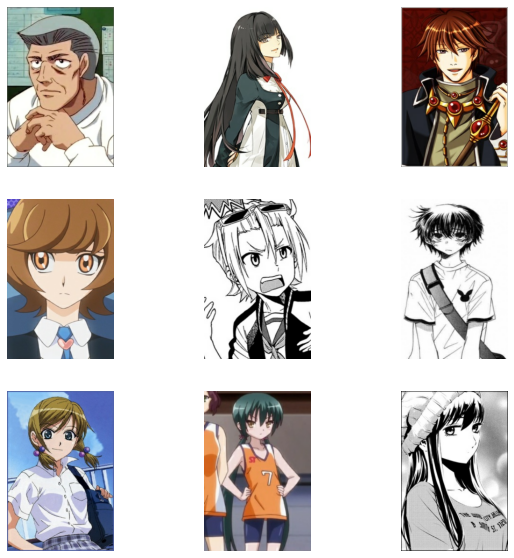

In [3]:
for image_batch in x_train:
    print(image_batch.shape)
    break

In [4]:
%%time
normalization_layer = tf.keras.layers.Rescaling(1./255)
# Batch and shuffle the data
def configure_for_performance(ds, name):
    ds = ds.cache(name)
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

normalized_ds = x_train.map(lambda x: (normalization_layer(x)))
image_batch = next(iter(normalized_ds))
# Cache keeps the images in memory after they're loaded off disk during the first epoch. 
# This will ensure the dataset does not become a bottleneck while training your model. 
# Prefetch overlaps data preprocessing and model execution while training.
# This allows later elements to be prepared while the current element is being processed. 
# This often improves latency and throughput, at the cost of using additional memory to store prefetched elements.
AUTOTUNE = tf.data.AUTOTUNE
print(normalized_ds)

train_ds = configure_for_performance(normalized_ds, "./cache/training_cashe")
val_ds = configure_for_performance(x_test, "./cache/testing_cashe")
for image_batch in train_ds:
    print(image_batch.shape)
    break
# print("image_batch", image_batch)
# print("train_dataset", train_dataset)
print("In range between: ", np.min(image_batch[0])," and: ", np.max(image_batch[0]))

In [5]:
def make_generator_model():
    print("Generating DCGAN model.")
    model = tf.keras.Sequential()
    print("Adding Dense...")
    model.add(layers.Dense(45*30*256, use_bias=False, input_shape=(100,)))
    print("Adding Batch Normalization...")
    model.add(layers.BatchNormalization())
    print("Adding Leaky ReLU...")
    model.add(layers.LeakyReLU())
    
    print("Reshape...")
    model.add(layers.Reshape((45, 30, 256)))
    print(model.output_shape)
    assert model.output_shape == (None, 45, 30, 256)  # Note: None is the batch size
    
    print("Adding Convolution...")
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    print(model.output_shape)
    assert model.output_shape == (None, 45, 30, 128)
    
    print("Adding 2nd Batch Normalization...")
    model.add(layers.BatchNormalization())
    print("Adding 2nd Leaky ReLU...")
    model.add(layers.LeakyReLU())
    print("Adding 2nd Convolution...")
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    print(model.output_shape)
    assert model.output_shape == (None, 90, 60, 64)
    
    print("Adding 3rd Batch Normalization...")
    model.add(layers.BatchNormalization())
    print("Adding 3rd Leaky ReLU...")
    model.add(layers.LeakyReLU())
    print("Adding 3rd Convolution...")
    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    print(model.output_shape)
    assert model.output_shape == (None, 180, 120, 32)
    
    print("Adding 4th Batch Normalization...")
    model.add(layers.BatchNormalization())
    print("Adding 4th Leaky ReLU...")
    model.add(layers.LeakyReLU())
    print("Adding 4th Convolution...")
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    print(model.output_shape)
    assert model.output_shape == (None, 360, 240, 3)
    
    print("DCGAN model completed")
    return model

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [6]:
%%time
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
print(generated_image.shape)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

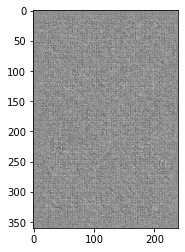

In [7]:

def make_discriminator_model():
    print("DCGAN descriminator model")
    model = tf.keras.Sequential()
    print("Adding Convolutional...")
    model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[360, 240, 3]))
    print("Adding Leaky Relu...")
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    print("Adding 2nd Convolutional...")
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    print("Adding 2nd Leaky Relu...")
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    print("Adding 3rd Convolutional...")
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    print("Adding 3rd Leaky Relu...")
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    print("Adding 4th Convolutional...")
    model.add(layers.Conv2D(356, (5, 5), strides=(2, 2), padding='same'))
    print("Adding 4th Leaky Relu...")
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    print("Adding Flatten...")
    model.add(layers.Flatten())
    print("Adding Dense...")
    model.add(layers.Dense(1))
    print(model.output_shape)
    print("DCGAN descriminator Completed!!")
    return model

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [8]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

In [9]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [10]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16
wandb.config = {
  "learning_rate": 0.001,
  "epochs": EPOCHS,
  "batch_size": BATCH_SIZE
}
# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])
# print("Seed :",seed)

# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    print("Training step")
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)
      print("generator.trainable_variables :",generator.trainable_variables)
      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def train(dataset, epochs):
  print("Training Start...")
  for epoch in range(epochs):
    print("Epoch :", epoch)
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  with tf.Session() as sess:
    wandb.tensorflow.log(tf.summary.merge_all())
  
  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [11]:
train(train_ds, EPOCHS)

Audio(url=the_creation, autoplay=True, rate=48000)

In [12]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16
wandb.config = {
  "learning_rate": 0.001,
  "epochs": EPOCHS,
  "batch_size": BATCH_SIZE
}
# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])
noise = tf.random.normal([BATCH_SIZE, noise_dim])
generated_images = generator(noise, training=True)
# print("Seed :",seed)

# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    print("Training step")
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      print("Generator for noise")
      
      print("Discriminator ca")
      real_output = discriminator(images, training=True)
      print("Generator called")
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      print("gen_loss :",gen_loss)
      disc_loss = discriminator_loss(real_output, fake_output)
      print("disc_loss :",disc_loss)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def train(dataset, epochs):
  print("Training Start...")
  for epoch in range(epochs):
    print("Epoch :", epoch)
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  with tf.Session() as sess:
    wandb.tensorflow.log(tf.summary.merge_all())
  
  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [13]:
tf.distribute.experimental.MultiWorkerMirroredStrategy(
    communication=tf.distribute.experimental.CollectiveCommunication.AUTO,
    cluster_resolver=None
)

train(train_ds, EPOCHS)

Audio(url=the_creation, autoplay=True, rate=48000)

In [14]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16
wandb.config = {
  "learning_rate": 0.001,
  "epochs": EPOCHS,
  "batch_size": BATCH_SIZE
}
# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])
noise = tf.random.normal([BATCH_SIZE, noise_dim])
# print("Seed :",seed)

# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    print("Training step")
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      print("Generator for noise")
      generated_images = generator(noise, training=True)
      print("Discriminator for images")
      real_output = discriminator(images, training=True)
      print("Discriminator for noise")
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      print("gen_loss :",gen_loss)
      disc_loss = discriminator_loss(real_output, fake_output)
      print("disc_loss :",disc_loss)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def train(dataset, epochs):
  print("Training Start...")
  for epoch in range(epochs):
    print("Epoch :", epoch)
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  with tf.Session() as sess:
    wandb.tensorflow.log(tf.summary.merge_all())
  
  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [15]:
%%time
tf.distribute.experimental.MultiWorkerMirroredStrategy(
    communication=tf.distribute.experimental.CollectiveCommunication.AUTO,
    cluster_resolver=None
)

train(train_ds, EPOCHS)

Audio(url=the_creation, autoplay=True, rate=48000)

In [16]:
from IPython.display import Audio
from IPython import display
the_voice = './sounds/chose_a_voice.wav'
the_creation = './sounds/You_created_me.wav'

import tensorflow as tf
from tensorflow import keras

# Error: Node: 'sequential_3/dropout_4/dropout/random_uniform/RandomUniform'
# OOM when allocating tensor with shape[256,180,120,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
# 	 [[{{node sequential_3/dropout_4/dropout/random_uniform/RandomUniform}}]]
# the solution to thi is report_tensor_allocations_upon_oom = True

import os
os.environ[‘TF_GPU_ALLOCATOR’] = ‘cuda_malloc_async’
print(os.getenv(‘TF_GPU_ALLOCATOR’))


run_opts = tf.compat.v1.RunOptions(report_tensor_allocations_upon_oom=True)
runmeta = tf.compat.v1.RunMetadata()

from tensorflow.keras import layers
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time
import wandb

# pip install wandb
# wandb login
# 65bacd21c40b0085e299e05ea94b552d5119b7bc

wandb.init(project="Anime Creation", entity="skycladai")

print("Note! You will need tensorflow-gpu version 2.8.0 or higher. Your version is", tf.__version__)
print(tf.config.list_physical_devices('GPU'))

Audio(url=the_voice, autoplay=True, rate=48000)

In [17]:
from IPython.display import Audio
from IPython import display
the_voice = './sounds/chose_a_voice.wav'
the_creation = './sounds/You_created_me.wav'

import tensorflow as tf
from tensorflow import keras

# Error: Node: 'sequential_3/dropout_4/dropout/random_uniform/RandomUniform'
# OOM when allocating tensor with shape[256,180,120,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
# 	 [[{{node sequential_3/dropout_4/dropout/random_uniform/RandomUniform}}]]
# the solution to thi is report_tensor_allocations_upon_oom = True

import os
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
print(os.getenv('TF_GPU_ALLOCATOR'))


run_opts = tf.compat.v1.RunOptions(report_tensor_allocations_upon_oom=True)
runmeta = tf.compat.v1.RunMetadata()

from tensorflow.keras import layers
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time
import wandb

# pip install wandb
# wandb login
# 65bacd21c40b0085e299e05ea94b552d5119b7bc

wandb.init(project="Anime Creation", entity="skycladai")

print("Note! You will need tensorflow-gpu version 2.8.0 or higher. Your version is", tf.__version__)
print(tf.config.list_physical_devices('GPU'))

Audio(url=the_voice, autoplay=True, rate=48000)